## Kubernetes allocation dynamique d'executeur

Dans le tutorial précédent nous avons que le driver spark lance un nombre fixe d'executeur pour répondre à tous les jobs spark.
L'objectif est maintenant de rendre ceci dynamique.

In [9]:
import os

In [10]:
from pyspark.sql import SparkSession

spark = (SparkSession 
         .builder
         # url par défaut d'une api kubernetes accédé depuis l'intérieur du cluster 
         # (ici le notebook tourne lui même dans kubernetes)
         .master("k8s://https://kubernetes.default.svc:443")
         # image des executors spark: pour des raisons de simplicité on réutilise l'image du notebook
         .config("spark.kubernetes.container.image", os.environ['IMAGE_NAME'])
         # Nom du namespace kubernetes
         .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE'])
         # Mémoire alloué à la JVM
         # Attention par défaut le pod kubernetes aura une limite supérieur qui dépend d'autres paramètres.
         # On manipulera plus bas pour vérifier la limite de mémoire totale d'un executeur
         .config("spark.executor.memory", "4g")
         .config("spark.kubernetes.driver.pod.name", os.environ['KUBERNETES_POD_NAME'])
         # configuration de la dynamicAllocation
         .config("spark.dynamicAllocation.enabled","true")
         .config("spark.dynamicAllocation.initialExecutors","1")
         .config("spark.dynamicAllocation.minExecutors","1")
         .config("spark.dynamicAllocation.maxExecutors","60")
         # Le ratio correspond aux nombres de pods à créer pour une nombre de taches parallèles 
         # (100 taches parrallèles, ratio 1, on vise 100 pods, avec 0.5 ce serait 50 pods)
         .config("spark.dynamicAllocation.executorAllocationRatio","1")
         .config("spark.dynamicAllocation.shuffleTracking.enabled","true")
         .getOrCreate()
        )

sc = spark.sparkContext

2021-11-04 13:15:33,348 WARN util.Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.
2021-11-04 13:15:33,434 WARN util.Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.
2021-11-04 13:15:33,435 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


Le contexte spark se lance et si l'on utilise un terminal pour afficher l'ensemble des pods qui sont dans notre namespace, on voit que spark a lancé un seul executeur sur le cluster kubernetes. Plutôt stylé !

On peut le vérifier facilement avec kubectl car le template spark pour un pod comporte le label `spark-role=executor`

In [11]:
! kubectl get pods -l spark-role=executor

I1104 13:15:41.061139    2906 request.go:665] Waited for 1.092642348s due to client-side throttling, not priority and fairness, request: GET:https://kubernetes.default/apis/ceph.rook.io/v1?timeout=32s
NAME                                    READY   STATUS    RESTARTS   AGE
pyspark-shell-1a27a87ceb171e0d-exec-1   1/1     Running   0          12s


ou sur l'ihm spark onglet executor

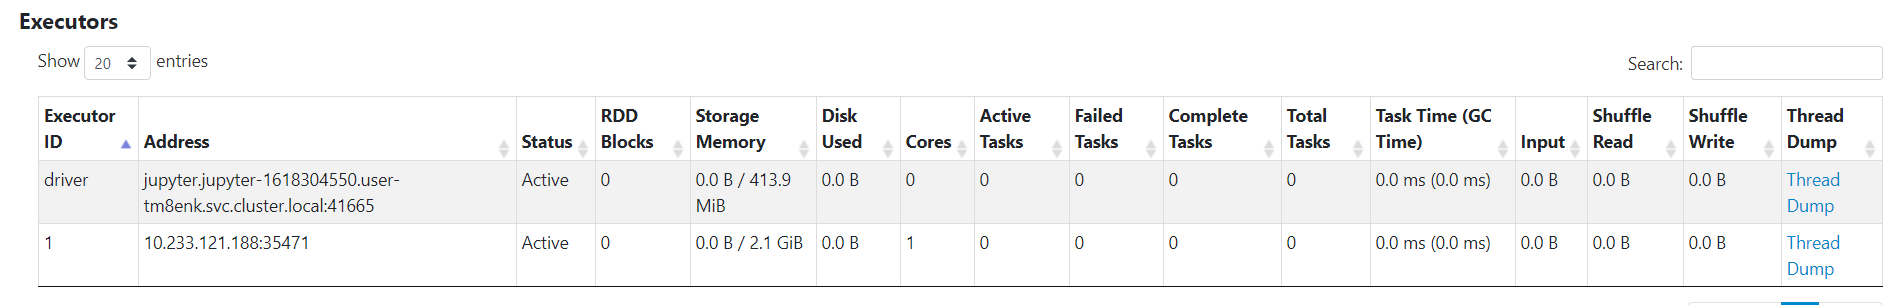

#### Les données : sirene opendata

On va réutiliser exactement les codes du tutorial précédant avec une allocation statique du nombre d'executeur.

In [4]:
import json
from pyspark.sql.types import StructType
import s3fs

endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})

with fs.open('s3://projet-spark-lab/diffusion/formation/schema/sirene/sirene.schema.json') as f:
    a = f.read()
    schema = StructType.fromJson(json.loads(a))

In [12]:
df = (spark.read
      .format("csv")
      .options(header='true', inferschema='false', delimiter=',')
      .schema(schema)
      .load("s3a://projet-spark-lab/diffusion/formation/data/sirene/sirene.csv")
     )

df.first()

Row(siren=325175, nic=16, siret=32517500016, dateFin='2007-12-31', dateDebut='2000-09-26', etatAdministratifEtablissement='A', changementEtatAdministratifEtablissement=False, enseigne1Etablissement=None, enseigne2Etablissement=None, enseigne3Etablissement=None, changementEnseigneEtablissement=False, denominationUsuelleEtablissement=None, changementDenominationUsuelleEtablissement=False, activitePrincipaleEtablissement=None, nomenclatureActivitePrincipaleEtablissement=None, changementActivitePrincipaleEtablissement='false', caractereEmployeurEtablissement='N', changementCaractereEmployeurEtablissement='false')

In [13]:
! kubectl get pods -l spark-role=executor

I1104 13:19:13.278646    2967 request.go:665] Waited for 1.010080566s due to client-side throttling, not priority and fairness, request: GET:https://kubernetes.default/apis/admissionregistration.k8s.io/v1?timeout=32s
NAME                                    READY   STATUS    RESTARTS   AGE
pyspark-shell-1a27a87ceb171e0d-exec-1   1/1     Running   0          3m45s


La requête first ne nécessite aucun parallélisme puisqu'on ne lit qu'une seule partition de donnée pour être en mesure de répondre.

### Augmentons le nombre de taches

Pour cela nous allons forcer la lecture de tout le csv. Cela se fera en fonction du nombre de partition du dataframe original. En effet spark dans sa configuration par défaut travaille sur 128 Mo de données et va donc découper le job sur les 6,5 Go en 53 taches 




In [24]:
%%timeit -r3
print(df.count())

7.55 s ± 95.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [25]:
# Count number of pods with "executor" as spark-role
!kubectl get pods -l spark-role=executor | wc -l

I1104 13:27:03.165342    3557 request.go:665] Waited for 1.098710123s due to client-side throttling, not priority and fairness, request: GET:https://kubernetes.default/apis/discovery.k8s.io/v1beta1?timeout=32s
53


Vous pouvez constater qu'on a bien lancé 53 executeurs dynamiquement.
Si vous attendez suffisamment longtemps sans envoyer de job à spark, les executeurs vont progressivement s'éteindre.

In [29]:
# Count number of pods with "executor" as spark-role
!kubectl get pods -l spark-role=executor | wc -l

I1104 13:28:35.031133    3709 request.go:665] Waited for 1.173633001s due to client-side throttling, not priority and fairness, request: GET:https://kubernetes.default/apis/velero.io/v1?timeout=32s
49


### Que se passe t'il pour le cache ?

La question qui vient dès lors qu'on fait de l'allocation dynamique est de voir comment fonctionne le cache des dataframe.
Va t'il empecher la fermeture des pods qui contiennent des partitions en cache ? 

In [30]:
df.cache()

DataFrame[siren: int, nic: int, siret: bigint, dateFin: string, dateDebut: string, etatAdministratifEtablissement: string, changementEtatAdministratifEtablissement: boolean, enseigne1Etablissement: string, enseigne2Etablissement: string, enseigne3Etablissement: string, changementEnseigneEtablissement: boolean, denominationUsuelleEtablissement: string, changementDenominationUsuelleEtablissement: boolean, activitePrincipaleEtablissement: string, nomenclatureActivitePrincipaleEtablissement: string, changementActivitePrincipaleEtablissement: string, caractereEmployeurEtablissement: string, changementCaractereEmployeurEtablissement: string]

In [34]:
%%timeit -r3
print(df.count())

69911542
69911542
69911542
69911542
346 ms ± 120 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [35]:
# Count number of pods with "executor" as spark-role
!kubectl get pods -l spark-role=executor | wc -l

I1104 13:32:29.558968    4001 request.go:665] Waited for 1.170355059s due to client-side throttling, not priority and fairness, request: GET:https://kubernetes.default/apis/node.k8s.io/v1?timeout=32s
54


**Le nombre d'executor ne décroit pas. Il semblerait que spark ne veuille pas perdre de partition.**

Je vais donc supprimer ce dataframe du cache mémoire

In [36]:
df.unpersist()

DataFrame[siren: int, nic: int, siret: bigint, dateFin: string, dateDebut: string, etatAdministratifEtablissement: string, changementEtatAdministratifEtablissement: boolean, enseigne1Etablissement: string, enseigne2Etablissement: string, enseigne3Etablissement: string, changementEnseigneEtablissement: boolean, denominationUsuelleEtablissement: string, changementDenominationUsuelleEtablissement: boolean, activitePrincipaleEtablissement: string, nomenclatureActivitePrincipaleEtablissement: string, changementActivitePrincipaleEtablissement: string, caractereEmployeurEtablissement: string, changementCaractereEmployeurEtablissement: string]

On vérifie sur l'ui que le dataframe n'est plus stocké en mémoire

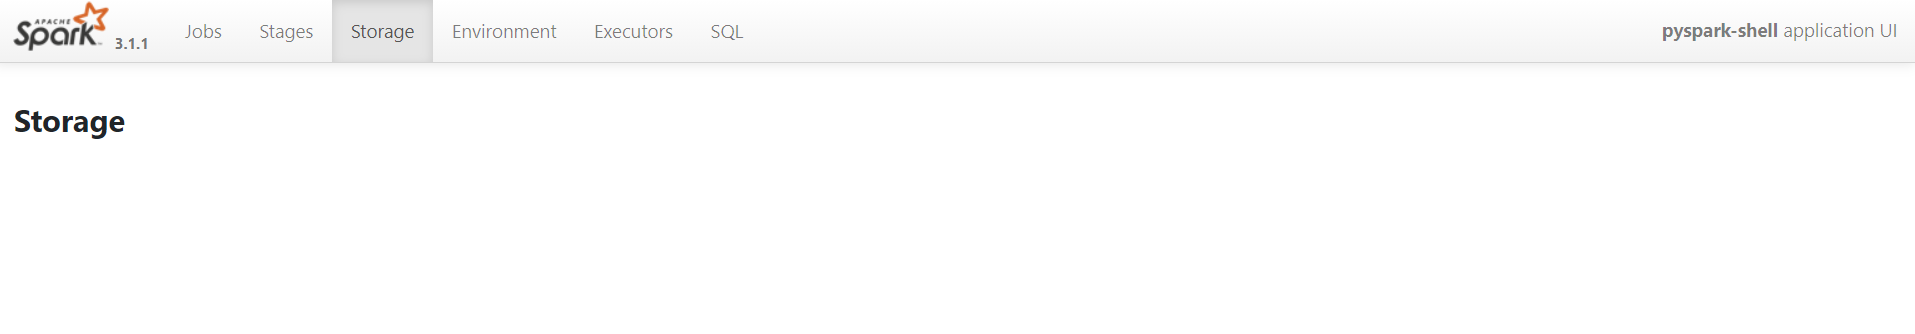

In [50]:
# Count number of pods with "executor" as spark-role
!kubectl get pods -l spark-role=executor | wc -l

I1104 13:38:31.802471    4511 request.go:665] Waited for 1.138079403s due to client-side throttling, not priority and fairness, request: GET:https://kubernetes.default/apis/cert-manager.io/v1beta1?timeout=32s
6


Et assez rapidement mes executeurs sont libérés.

### Conclusion

L'allocation dynamique permet de reserver des ressources uniquement quand vous en avez besoin.
Vous avez les deux parametres suivants pour gerer l'extinction des pods qui confirme ce que nous avons pu observer dans le tutorial.

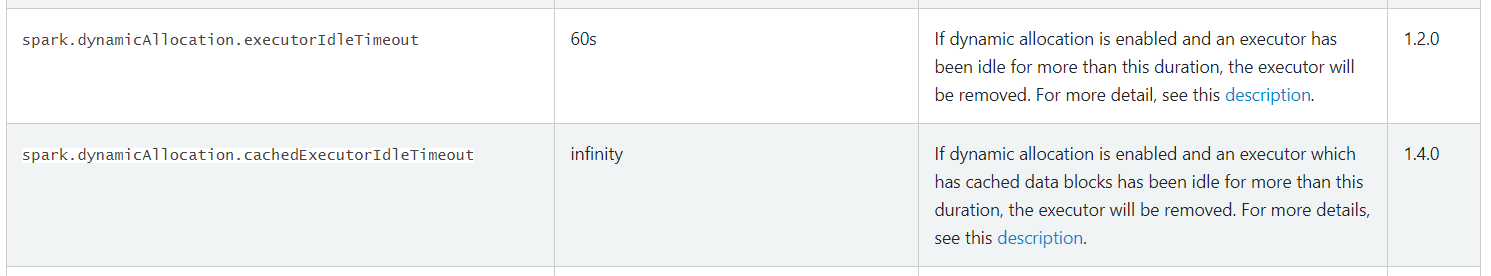

In [20]:
spark.stop()